## Imports

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import random
import torch.nn as nn
from torchvision.models import vgg16
import torch.optim as optim
from tqdm import tqdm

import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim

import torchvision.utils as vutils
import matplotlib.pyplot as plt

import os

import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from torchsummary import summary

from google.colab import drive

from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import tensorflow as tf
import keras
import os
import shutil

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Mounting the Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## PREPROCESSING

### Create Custom Dataset Class

In [ ]:
class ImageColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, root='./', transform=None):
        self.root = root
        self.transform = transform
        self.init_dataset()

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        image = self.x_train[idx]
        label = self.y_train[idx]
        
        image = Image.open(image)
        label = Image.open(label)

        if self.transform:
            image, label = self.transform(image, label)        

        return (image, label)

    def init_dataset(self):

        from urllib import request
        import zipfile
        import os
        from PIL import Image

        path_to_dataset = 'https://d1u36hdvoy9y69.cloudfront.net/cs-228-intro-to-dl/Project/dataset.zip'
        path_to_zip = f'{self.root}/dataset.zip'
        base_path = f'{self.root}/'
        path_to_bw = f'{base_path}/dataset/bw_images'
        path_to_colored = f'{base_path}/dataset/true_images'


        if not os.path.exists(self.root):
            os.makedirs(self.root)

        request.urlretrieve(path_to_dataset, path_to_zip)
        
        with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
            zip_ref.extractall(base_path)

        
        self.x_train = []
        self.y_train = []

        for (dirpath, dirnames, filenames) in os.walk(f'{path_to_bw}'):

            for filename in filenames:
                img_path = dirpath +'/'+ filename
                self.x_train.append(img_path)

                lbl_path = f'{path_to_colored}/'+ filename
                self.y_train.append(lbl_path)

### Custom Transforms

In [ ]:
class CustomRotate(object):
    def __init__(self, rot_low=200, rot_high=360, rot_prob=0.5):
        # Rotation Augmentation
        random_number = torch.randint(rot_low, rot_high, (1,))
        self.angle = random_number.item()
        self.rot_prob = rot_prob
        
    def __call__(self, image, label):
        if torch.rand(1).item() < self.rot_prob:
            image = image.rotate(self.angle)
            label = label.rotate(self.angle)

        return image, label

class CustomVertFlip(object):
    def __init__(self, vert_flip_prob=0.5):
        # Vertical Flip
        self.vert_flip_prob = vert_flip_prob

    def __call__(self, image, label):
        if torch.rand(1).item() < self.vert_flip_prob:
            image = torchvision.transforms.functional.vflip(image)
            label = torchvision.transforms.functional.vflip(label)

        return image, label

class CustomHorFip(object):
    def __init__(self, hor_flip_prob=0.5):
        # Horizontal Flip
        self.hor_flip_prob = hor_flip_prob

    def __call__(self, image, label):
        if torch.rand(1).item() < self.hor_flip_prob:
            image = torchvision.transforms.functional.hflip(image)
            label = torchvision.transforms.functional.hflip(label)

        return image, label
    
class CustomBlur(object):
    def __init__(self, gauss_blur_prob=0.5, gauss_blur_rad = 5):
        # Gaussian Blur
        self.gauss_blur_prob = gauss_blur_prob
        self.gauss_blur_rad = gauss_blur_rad

        
    def __call__(self, image, label):
        if torch.rand(1).item() < self.gauss_blur_prob:
            image = image.filter(ImageFilter.GaussianBlur(radius=self.gauss_blur_rad))
            label = label.filter(ImageFilter.GaussianBlur(radius=self.gauss_blur_rad))

        return image, label

class CustomToTensor(object):
    def __init__(self):
        pass
        
    def __call__(self, image, label):
        image = torchvision.transforms.functional.to_tensor(image)
        label = torchvision.transforms.functional.to_tensor(label)

        return image, label

class CustomRandomCrop(object):
    def __init__(self, crop_size=(128,128), crop_prob=0.5, n_holes=1):
        self.crop_size = crop_size
        self.crop_prob = crop_prob
        self.n_holes = n_holes

    def __call__(self, image, label):
        _, height, width = image.shape
        mask = torch.ones_like(image)
        
        for _ in range(self.n_holes):
            left = random.randint(0, width - self.crop_size[0])
            top = random.randint(0, height - self.crop_size[1])
            right = left + self.crop_size[0]
            bottom = top + self.crop_size[1]
            
            mask[:, top:bottom, left:right] = 0

        image = image * mask
        # label = label * mask
        return image, label

class CustomCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, label):
        for transform in self.transforms:
            image, label = transform(image, label)
        return image, label

### Visualize Individual Transformations

In [ ]:
transforms_plain = CustomCompose([
    CustomToTensor()
])
dataset_plain = ImageColorizationDataset(root = './dataset2', transform=transforms_plain)

transforms_rotated = CustomCompose([
    CustomRotate(rot_low=100, rot_high=300, rot_prob=1),
    CustomToTensor()
])
dataset_rotated = ImageColorizationDataset(root = './dataset2', transform=transforms_rotated)

transforms_hflipped = CustomCompose([
    CustomHorFip(hor_flip_prob=1),
    CustomToTensor()
])
dataset_hflipped = ImageColorizationDataset(root = './dataset2', transform=transforms_hflipped)

transforms_vflipped = CustomCompose([
    CustomVertFlip(vert_flip_prob=1),
    CustomToTensor()
])
dataset_vflipped = ImageColorizationDataset(root = './dataset2', transform=transforms_vflipped)

# transforms_blurred = CustomCompose([
#     CustomBlur(gauss_blur_prob=1, gauss_blur_rad=10),
#     CustomToTensor()
# ])
# dataset_blurred = ImageColorizationDataset(root = './dataset2', transform=transforms_blurred)

transforms_cropped = CustomCompose([
    CustomToTensor(),
    CustomRandomCrop(crop_size=(200,200), crop_prob=1, n_holes=2)
])
dataset_cropped = ImageColorizationDataset(root = './dataset2', transform=transforms_cropped)

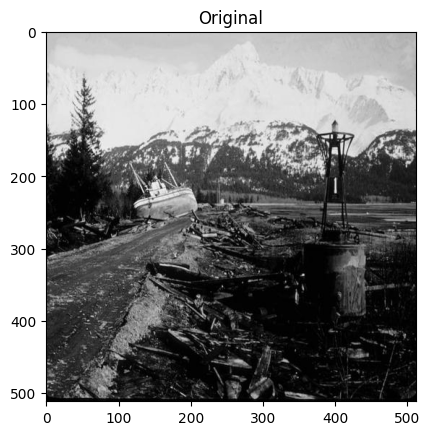

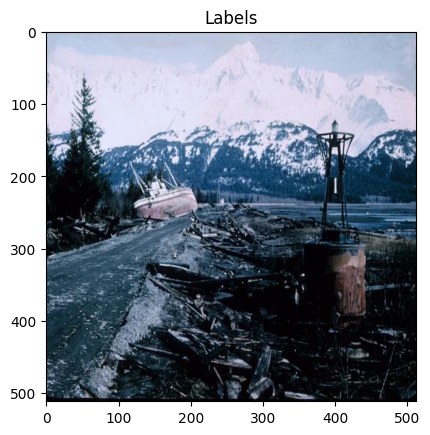

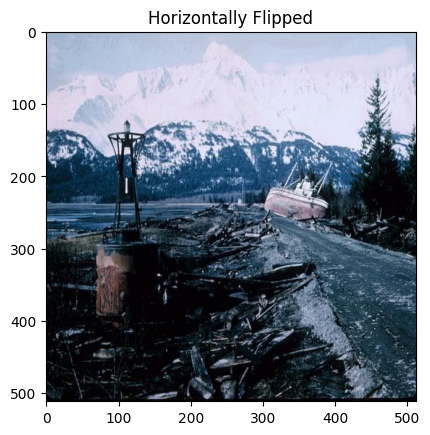

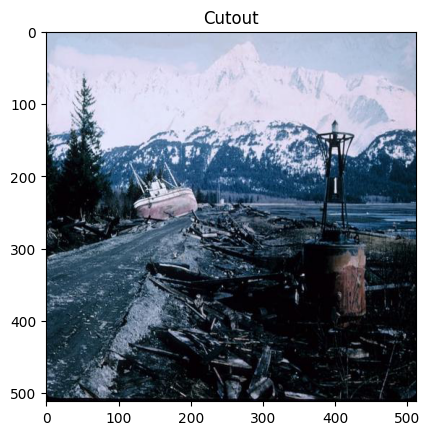

In [ ]:
idx = 2000
image_plain, label_plain = dataset_plain[idx]
image_rotated, label_rotated = dataset_rotated[idx]
image_hflipped, label_hflipped = dataset_hflipped[idx]
image_vflipped, label_vflipped = dataset_vflipped[idx]
# image_blurred, label_blurred = dataset_blurred[idx]
image_cropped, label_cropped = dataset_cropped[idx]

plt.figure(1)
plt.imshow(image_plain.squeeze(0), cmap='gray')
plt.title('Original')
plt.plot()
plt.show()

plt.figure(1)
plt.imshow(label_plain.permute(1,2,0))
plt.title('Labels')
plt.plot()
plt.show()

plt.figure(1)
plt.imshow(label_rotated.permute(1,2,0))
plt.title('Rotated')
plt.plot()
plt.show()

plt.figure(1)
plt.imshow(label_hflipped.permute(1,2,0))
plt.title('Horizontally Flipped')
plt.plot()
plt.show()

plt.figure(1)
plt.imshow(label_vflipped.permute(1,2,0))
plt.title('Vertically Flipped')
plt.plot()
plt.show()

# plt.figure(1)
# plt.imshow(label_blurred.permute(1,2,0))
# plt.title('Gaussian Blurred')
# plt.plot()
# plt.show()

plt.figure(1)
plt.imshow(label_cropped.permute(1,2,0))
plt.title('Cutout')
plt.plot()
plt.show()


### Create dataloaders

In [ ]:
transforms = CustomCompose([
    CustomRotate(rot_low=100, rot_high=300, rot_prob=0.5),
    CustomVertFlip(vert_flip_prob=0.5),
    CustomHorFip(hor_flip_prob=0.5),
    # CustomBlur(gauss_blur_prob=0.5, gauss_blur_rad=5),
    CustomToTensor(),
    CustomRandomCrop(crop_size=(200,200), crop_prob=1, n_holes=2)
])

image_colorization_dataset = ImageColorizationDataset(root = './dataset', transform=transforms)

train_ratio = 0.75
test_ratio = 0.2
val_ratio = 0.05

train_size = int(len(image_colorization_dataset) * train_ratio)
val_size = int(len(image_colorization_dataset) * val_ratio)
test_size = len(image_colorization_dataset) - train_size - val_size

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(image_colorization_dataset, [train_size, test_size, val_size])

In [ ]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

### Use DataLoaders

In [ ]:
len(train_loader), len(test_loader), len(val_loader)

(172, 46, 12)

In [ ]:
# Iterate over training data loader
print("Training Data:")
for batch_idx, (data, target) in enumerate(train_loader):
    # Print batch index and shape of data and target
    print("Batch Index:", batch_idx)
    print("Data Shape:", data.shape)
    print("Target Shape:", target.shape)
    print()
    break

# Iterate over testing data loader
print("Testing Data:")
for batch_idx, (data, target) in enumerate(test_loader):
    # Print batch index and shape of data and target
    print("Batch Index:", batch_idx)
    print("Data Shape:", data.shape)
    print("Target Shape:", target.shape)
    print()
    break

# Iterate over validation data loader
print("Validation Data:")
for batch_idx, (data, target) in enumerate(val_loader):
    # Print batch index and shape of data and target
    print("Batch Index:", batch_idx)
    print("Data Shape:", data.shape)
    print("Target Shape:", target.shape)
    print()
    break


Training Data:
Batch Index: 0
Data Shape: torch.Size([16, 1, 512, 512])
Target Shape: torch.Size([16, 3, 512, 512])

Testing Data:
Batch Index: 0
Data Shape: torch.Size([16, 1, 512, 512])
Target Shape: torch.Size([16, 3, 512, 512])

Validation Data:
Batch Index: 0
Data Shape: torch.Size([16, 1, 512, 512])
Target Shape: torch.Size([16, 3, 512, 512])



### Visualize Some Samples

Batch Index: 0
Data Shape: torch.Size([16, 1, 512, 512])
Target Shape: torch.Size([16, 3, 512, 512])



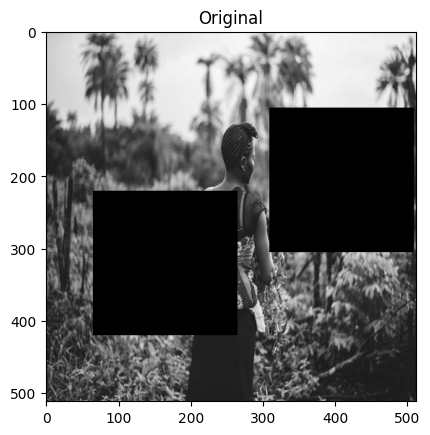

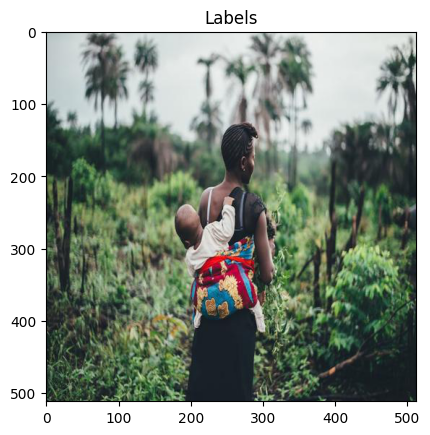

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    # Print batch index and shape of data and target
    print("Batch Index:", batch_idx)
    print("Data Shape:", data.shape)
    print("Target Shape:", target.shape)
    print()
    image = data[0]
    label = target[0]

    plt.figure(1)
    plt.imshow(image.squeeze(0), cmap='gray')
    plt.title('Original')
    plt.plot()
    plt.show()

    plt.figure(1)
    plt.imshow(label.permute(1,2,0))
    plt.title('Labels')
    plt.plot()
    plt.show()
    break

Batch Index: 0
Data Shape: torch.Size([16, 1, 512, 512])
Target Shape: torch.Size([16, 3, 512, 512])



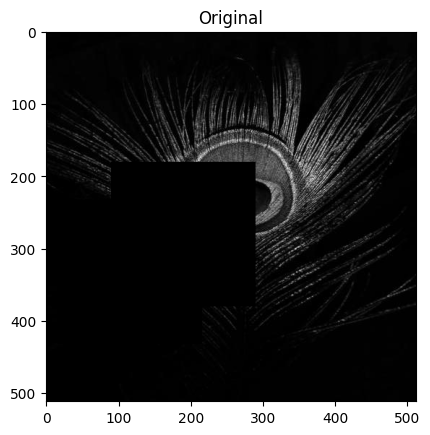

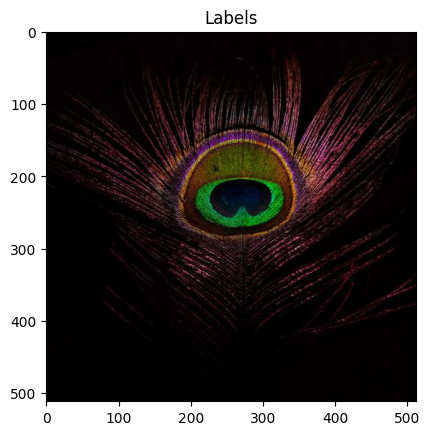

In [ ]:
for batch_idx, (data, target) in enumerate(test_loader):
    # Print batch index and shape of data and target
    print("Batch Index:", batch_idx)
    print("Data Shape:", data.shape)
    print("Target Shape:", target.shape)
    print()
    image = data[0]
    label = target[0]

    plt.figure(1)
    plt.imshow(image.squeeze(0), cmap='gray')
    plt.title('Original')
    plt.plot()
    plt.show()

    plt.figure(1)
    plt.imshow(label.permute(1,2,0))
    plt.title('Labels')
    plt.plot()
    plt.show()
    break

Batch Index: 0
Data Shape: torch.Size([16, 1, 512, 512])
Target Shape: torch.Size([16, 3, 512, 512])



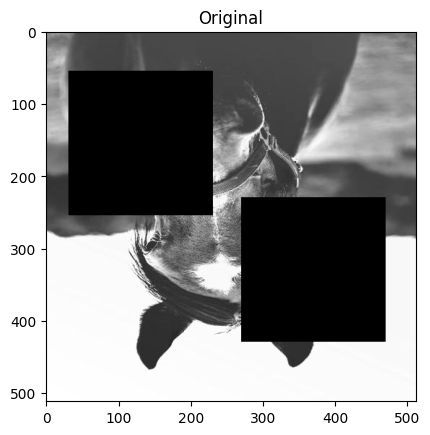

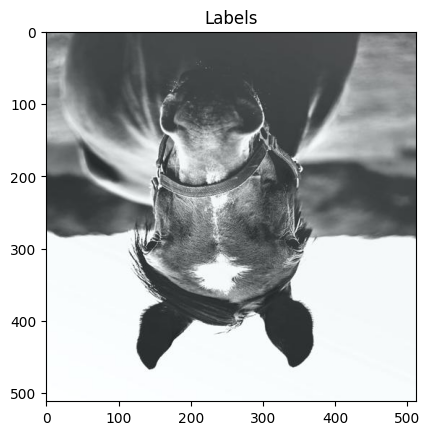

In [ ]:
for batch_idx, (data, target) in enumerate(val_loader):
    # Print batch index and shape of data and target
    print("Batch Index:", batch_idx)
    print("Data Shape:", data.shape)
    print("Target Shape:", target.shape)
    print()
    image = data[0]
    label = target[0]

    plt.figure(1)
    plt.imshow(image.squeeze(0), cmap='gray')
    plt.title('Original')
    plt.plot()
    plt.show()

    plt.figure(1)
    plt.imshow(label.permute(1,2,0))
    plt.title('Labels')
    plt.plot()
    plt.show()
    break

## *WORKING ON THE MODEL*

In [ ]:
"""
Because we are going to replace the encoder part with VGG16, 
we don’t need it as a classifier, we need it as a feature extractor so, 
the last dense layers isn’t needed we have to pop them up.

here, we iterate on each layer except the last dense layers so, 
we add 19 layer to our model. the dimension of last layer volume is “7x7x512”. 
we will be using that latent space volume as a feature vector to be input to the decoder.
 and the decoder is going to learn the mapping from the latent space vector to ab channels. 
 we want the layers of VGG16 with its original weights without changing them, 
 so that we set the trainable parameter in each layer to false because we don’t want to train them again.
"""
# Load the VGG16 model
vggmodel = vgg16.VGG16()

# Create a new sequential model
newmodel = Sequential()

# Iterate through the layers of the VGG16 model
for i, layer in enumerate(vggmodel.layers):
    if i < 19:  # Include layers up to the 19th layer for feature extraction
        newmodel.add(layer)

# Set all layers in the new model as non-trainable
for layer in newmodel.layers:
    layer.trainable = False

# Display the summary of the partial VGG16 model
newmodel.summary()

553467096/553467096 [==============================] - 24s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                      

In [ ]:
"""
VGG16 is expecting an image of 3 dimension with size 224x224 as an input, 
in preprocessing we have to scale all images to 224 instead of 256
"""
path = '/content/dataset2/dataset'
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255)

train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=32, class_mode=None)

Found 7324 images belonging to 2 classes.


In [ ]:
#Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to Lab. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.

"""

X = []
Y = []

# Iterate through the images in the 'train' dataset
for img in train[0]:
    try:
        # Convert RGB image to LAB color space
        lab = rgb2lab(img)

        # Extract the L channel and append to X
        X.append(lab[:, :, 0])

        # Extract the AB channels, normalize values, and append to Y
        Y.append(lab[:, :, 1:] / 128)  # A and B values range from -127 to 128, so we divide the values by 128 to restrict them to between -1 and 1.

    except:
        print('error')

# Convert X and Y lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Reshape X to add an extra dimension
X = X.reshape(X.shape + (1,))  # Dimensions to be the same for X and Y

# Print the shapes of X and Y arrays
print('Shape of X (Array containing L channels):', X.shape)
print('Shape of Y(Array containing AB channels):', Y.shape)

Shape of X (Array containing L channels): (32, 224, 224, 1)
Shape of Y(Array containing AB channels): (32, 224, 224, 2)


In [ ]:
#now we have one channel of L in each layer but, VGG16 is expecting 3 dimension, 
#so we repeated the L channel two times to get 3 dimensions of the same L channel

vggfeatures = []

# Iterate through each sample in X
for i, sample in enumerate(X):
    # Convert grayscale image to RGB
    sample = gray2rgb(sample)

    # Reshape sample to match the input shape of the newmodel
    sample = sample.reshape((1, 224, 224, 3))

    # Pass the sample through the newmodel for prediction
    prediction = newmodel.predict(sample)

    # Reshape the prediction to match the expected shape
    prediction = prediction.reshape((7, 7, 512))

    # Append the prediction to the vggfeatures list
    vggfeatures.append(prediction)

# Convert vggfeatures list to numpy array
vggfeatures = np.array(vggfeatures)

# Print the shape of vggfeatures array
print('Features of VGG are of the shape:', vggfeatures.shape)


# Decoder model
model = Sequential()

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(7, 7, 512)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

# Display the summary of the model
model.summary()

# Compile the model
model.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])

# Train the model
model.fit(vggfeatures, Y, verbose=1, epochs=1000, batch_size=16)

# Save the model
model.save('colorize_autoencoder_VGG16.model')

1/1 [==============================] - 0s 26ms/step
(32, 7, 7, 512)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                    

1/1 [==============================] - 0s 32ms/step
(32, 7, 7, 512)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d_5 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_6 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                    

In [ ]:
# Saving the model weights
model.save('/content/drive/MyDrive/Spring 2023/CS 228 Deep Learning/Projects/savedModelDetails/colorize_autoencoder_VGG16[3].model')

In [ ]:
# This is a code to bring the model details folder to the runtime
#  (as it was not able to fetch the folder directly from the drive itself)

folder_path = '/content/drive/MyDrive/Spring2023/CS228DeepLearning/Projects/savedModelDetails/colorize_autoencoder_VGG16[3].model'

destination_path = '/content/colorize_autoencoder_VGG16[3].model'

shutil.copytree(folder_path, destination_path)

'/content/colorize_autoencoder_VGG16[3].model'

## *PEDICTING USING THE SAVED MODEL*

In [ ]:
# Loading the model details
model = tf.keras.models.load_model('/content/colorize_autoencoder_VGG163.model',
                                   custom_objects=None,
                                   compile=True)

# Initializing the testpath and fetching images from that folder
testpath = '/content/dataset2/dataset/bw_images/'
files = os.listdir(testpath)

# Iterate through each file in the testpath
for idx, file in enumerate(files):
    # Load the image and resize it
    test = img_to_array(load_img(testpath+file))
    test = resize(test, (224, 224), anti_aliasing=True)
    test *= 1.0/255

    # Convert the image to LAB color space
    lab = rgb2lab(test)
    l = lab[:, :, 0]

    # Convert L channel to RGB format
    L = gray2rgb(l)
    L = L.reshape((1, 224, 224, 3))

    # Pass the L channel through the newmodel for prediction
    vggpred = newmodel.predict(L)

    # Pass the vggpred through the model for colorization prediction
    ab = model.predict(vggpred)
    ab = ab * 128

    # Create a new LAB image
    cur = np.zeros((224, 224, 3))
    cur[:, :, 0] = l
    cur[:, :, 1:] = ab

    # Convert the LAB image to RGB
    rgb_image = lab2rgb(cur)

    # Convert the RGB image to uint8 format (to cater the need of imsave functions)
    rgb_image_uint8 = (rgb_image * 255).astype(np.uint8)

    # Save the colorized image
    imsave('/content/drive/MyDrive/Spring2023/CS228DeepLearning/Projects/final_vgg_results/'+str(idx)+".jpg", rgb_image_uint8)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step


## *VISUALIZING THE PREDICTIONS*

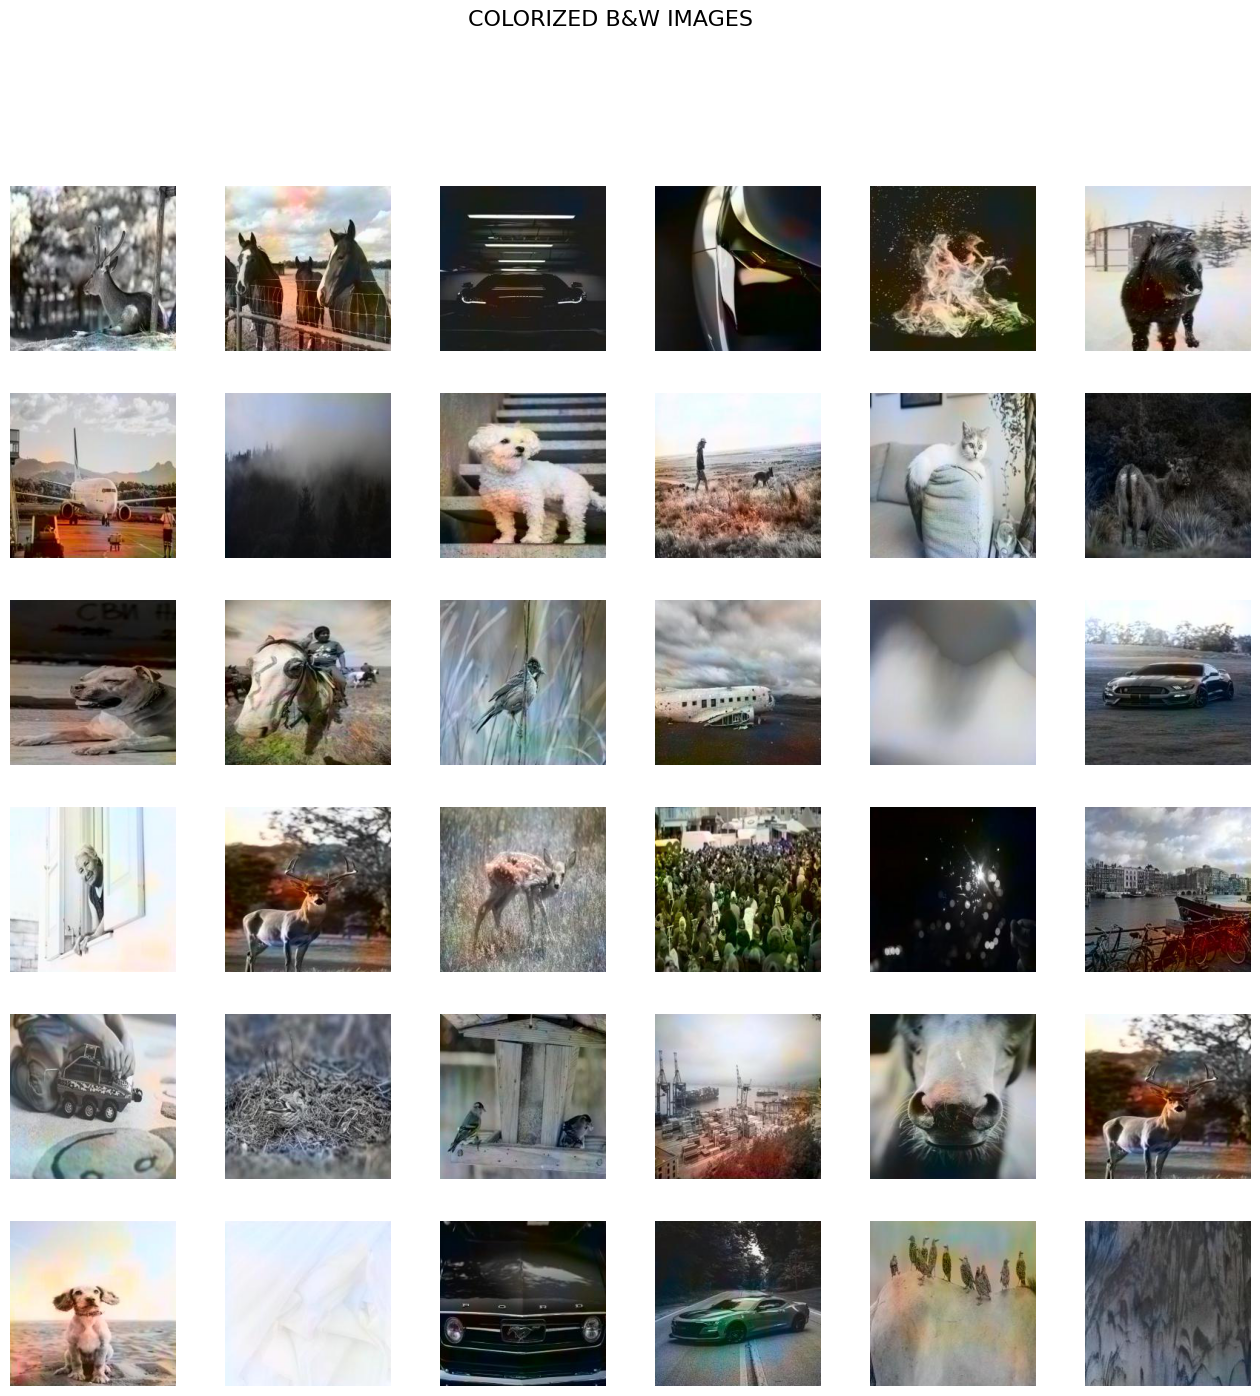

In [ ]:
# Path to the folder containing your pictures on Google Drive
folder_path = '/content/drive/MyDrive/Spring2023/CS228DeepLearning/Projects/final_vgg_results'

# Getting a list of all files in the folder
file_list = os.listdir(folder_path)

# Selecting 36 random files from the list
random_files = random.sample(file_list, 36)

# Create a square grid to display the images
fig, axs = plt.subplots(6, 6, figsize=(16, 16))
fig.suptitle('COLORIZED B&W IMAGES', fontsize=16)

# Iterate over the selected files and display the images in the grid
for i, file_name in enumerate(random_files):
    row = i // 6
    col = i % 6
    file_path = os.path.join(folder_path, file_name)
    try:
        img = Image.open(file_path)
        axs[row, col].imshow(img)
        axs[row, col].axis('off')
    except Exception as e:
        print(f"Error opening image file {file_name}: {e}")

# Adjust spacing and display the grid
plt.subplots_adjust(hspace=0.05, wspace=0.3)
plt.show()